# Estimating COVID-19's $R_t$ in Real-Time for EU - results

Data and estimates from April 23. See the `Realtime R0` notebook for how numbers here were derived.

In [69]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

COUNTRIES_INCLUDED = sorted(['Austria', 'Italy', 'Belgium', 'Latvia', 'Bulgaria', 'Lithuania', 'Croatia', 'Luxembourg', 
                      'Cyprus', 'Malta', 'Czechia', 'Netherlands', 'Denmark', 'Poland', 'Estonia', 'Portugal', 
                      'Finland', 'Romania', 'France', 'Slovakia', 'Germany', 'Slovenia', 'Greece', 'Spain', 
                      'Hungary', 'Sweden', 'Ireland', 'Russia', 'Norway', 'Switzerland'])

%config InlineBackend.figure_format = 'retina'

In [70]:
def plot_rt(result, ax, country_name, scatter_alpha=1.0):
    
    ax.set_title(f"{country_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['median'].index.get_level_values('date')
    values = result['median'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               alpha=scatter_alpha,
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['lower_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['upper_90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 2.0)
    ax.set_xlim(pd.Timestamp('2020-03-01'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')

In [71]:
final_results = pd.read_csv('data/rt_mcmc.csv',
                            parse_dates=['date'],infer_datetime_format=True,
                            index_col=['region', 'date'],
                            squeeze=True)

In [72]:
final_results

mean    median  lower_90  upper_90  lower_50  \
region         date                                                           
Austria        2020-02-16  1.579223  1.513297  1.112100  2.091127  1.255308   
               2020-02-17  1.585400  1.522372  1.117258  2.091524  1.247809   
               2020-02-18  1.589930  1.524495  1.127254  2.081264  1.269753   
               2020-02-19  1.597868  1.533115  1.131430  2.090966  1.288500   
               2020-02-20  1.603397  1.540904  1.135039  2.090860  1.233899   
...                             ...       ...       ...       ...       ...   
United_Kingdom 2020-06-05  0.888587  0.899009  0.766030  1.013447  0.875841   
               2020-06-06  0.886219  0.898677  0.742203  1.010146  0.867681   
               2020-06-07  0.884897  0.898278  0.729781  1.016731  0.858038   
               2020-06-08  0.884561  0.897090  0.718731  1.029261  0.864994   
               2020-06-09  0.884570  0.898438  0.713051  1.042479  0.852037   

                           upper_50  
region         date                  
Austria        2020-02-16  1.624118  
               2020-02-17  1.614279  
               2020-02-18  1.630810  
               2020-02-19  1.651094  
               2020-02-20  1.597405  
...                             ...  
United_Kingdom 2020-06-05  0.970622  
               2020-06-06  0.969149  
               2020-06-07  0.964874  
               2020-06-08  0.980371  
               2020-06-09  0.974019  

[3680 rows x 6 columns]

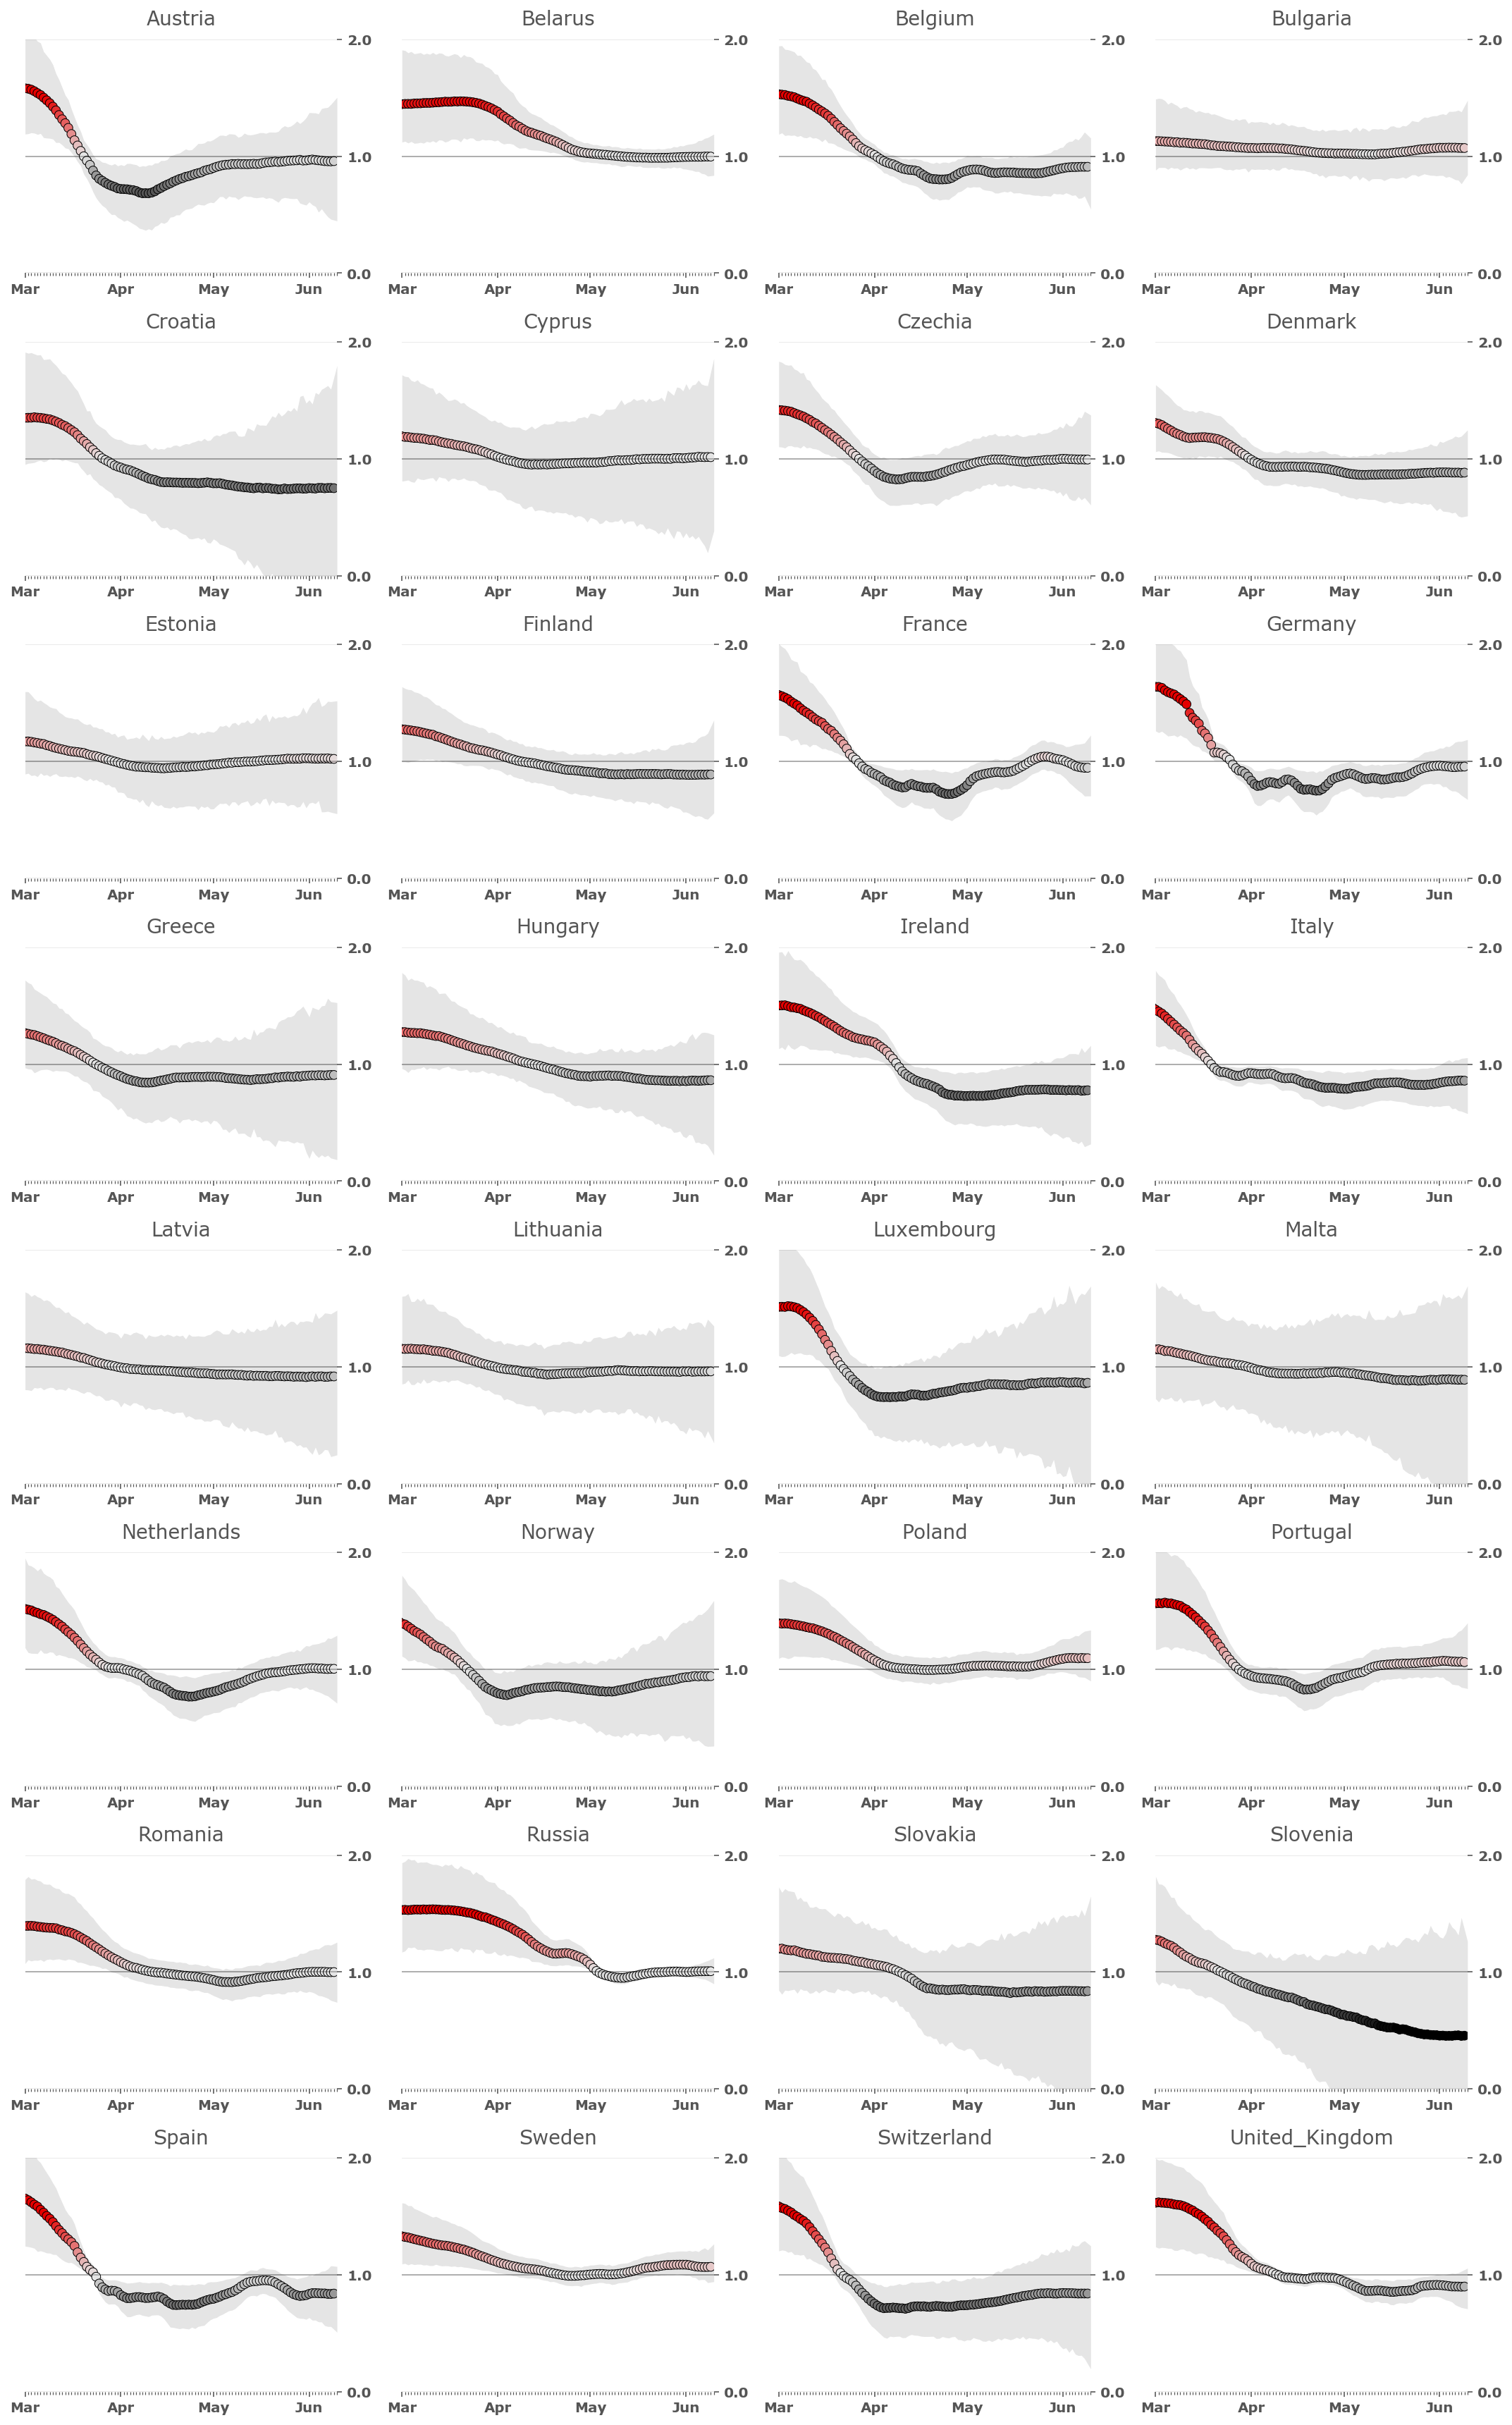

In [73]:
ncountries = len(final_results.index.unique(level='region'))
ncols = 4
nrows = int(np.ceil(ncountries / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

for i, (country_name, result) in enumerate(final_results.groupby('region')):
    plot_rt(result.iloc[1:], axes.flat[i], country_name)

fig.tight_layout()
fig.set_facecolor('w')

## Standings

In [74]:
FULL_COLOR = [.7,.7,.7]
NONE_COLOR = [179/255,35/255,14/255]
PARTIAL_COLOR = [.5,.5,.5]
ERROR_BAR_COLOR = [.3,.3,.3]

In [75]:
no_lockdown = []
partial_lockdown = []

In [76]:
def plot_standings(mr, figsize=None, title='Most Recent $R_t$ by Country'):
    if not figsize:
        figsize = ((15.9/50)*len(mr)+.1,2.5)
        
    fig, ax = plt.subplots(figsize=figsize)

    ax.set_title(title)
    err = mr[['lower_90', 'upper_90']].sub(mr['median'], axis=0).abs()
    bars = ax.bar(mr.index,
                  mr['median'],
                  width=.825,
                  color=FULL_COLOR,
                  ecolor=ERROR_BAR_COLOR,
                  capsize=2,
                  error_kw={'alpha':.5, 'lw':1},
                  yerr=err.values.T)
    
    too_uncertain = mr.index[(mr['upper_90'] - mr['lower_90']) > 1.2]

    for bar, country_name in zip(bars, mr.index):
        if country_name in no_lockdown:
            bar.set_color(NONE_COLOR)
        if country_name in partial_lockdown:
            bar.set_color(PARTIAL_COLOR)
        if country_name in too_uncertain:
            bar.set_alpha(0.3)

    labels = mr.index.to_series().replace({'District of Columbia':'DC'})
    ax.set_xticklabels(labels, rotation=90, fontsize=11)
    ax.margins(0)
    ax.set_ylim(0,2.)
    ax.axhline(1.0, linestyle=':', color='k', lw=1)
    
    if not too_uncertain.empty:
        leg = ax.legend(handles=[
                    Patch(label='Insufficient data or an end of epidemy', color=FULL_COLOR, alpha=0.3),
                ],
#                 title='Lockdown',
#                 ncol=3,
                loc='upper left',
                columnspacing=.75,
                handletextpad=.5,
                handlelength=1)
        leg._legend_box.align = "left"

        
    fig.set_facecolor('w')
    return fig, ax

               median  upper_90  lower_90
region                                   
Austria      0.958624  1.473268  0.453943
Belgium      0.910025  1.181197  0.603370
Bulgaria     1.070543  1.429426  0.802785
Croatia      0.749595  1.697894 -0.235203
Cyprus       1.014840  1.742985  0.289798
Czechia      0.994283  1.390686  0.637083
Denmark      0.882752  1.220743  0.506968
Estonia      1.022415  1.515495  0.559457
Finland      0.889009  1.297825  0.532789
France       0.946511  1.191808  0.704902
Germany      0.956728  1.179839  0.692936
Greece       0.907553  1.530057  0.189445
Hungary      0.862543  1.259174  0.262001
Ireland      0.776582  1.130253  0.305085
Italy        0.858593  1.052113  0.586889
Latvia       0.917551  1.467794  0.238470
Lithuania    0.960534  1.377599  0.400652
Luxembourg   0.863041  1.653306 -0.045178
Malta        0.888860  1.638346 -0.151939
Netherlands  1.005046  1.277184  0.731354
Norway       0.942473  1.552262  0.342489
Poland       1.096045  1.331445  0

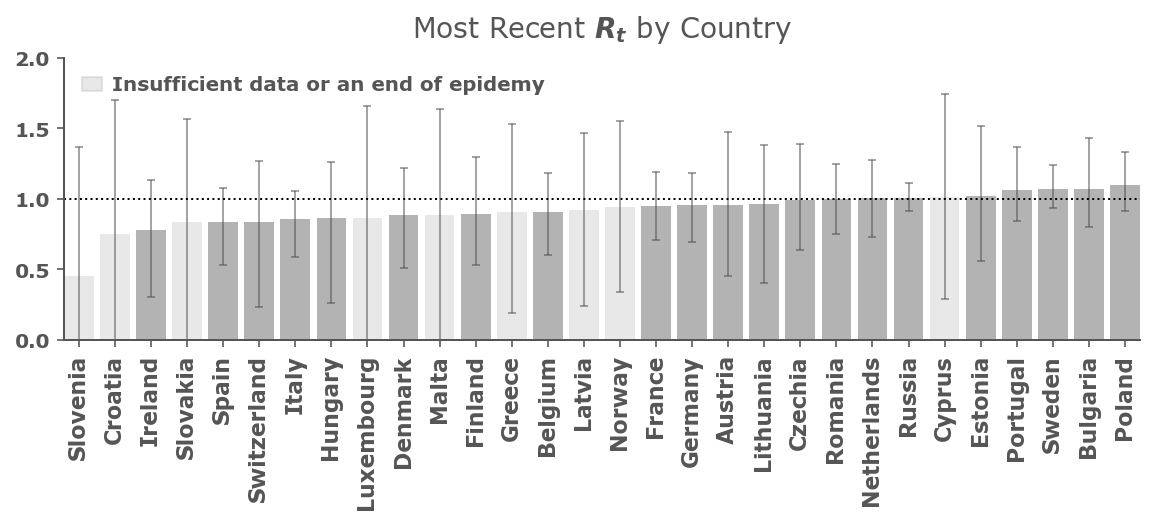

In [77]:
targets = final_results.index.get_level_values('region').isin(COUNTRIES_INCLUDED)
mr = final_results.loc[targets].groupby(level=0)[['median', 'upper_90', 'lower_90']].last()

print(mr)

mr.sort_values('median', inplace=True)
fig, ax = plot_standings(mr)

# Rainier

In [78]:
final_results_rainier = pd.read_csv('data/rt-rainier.csv',
                            parse_dates=['date'],infer_datetime_format=True,
                            index_col=['region', 'date'],
                            squeeze=True)

In [79]:
final_results_rainier

mean    median  lower_90  upper_90  lower_50  \
region         date                                                           
Austria        2020-02-06  1.556954  1.504146  1.074120  2.083162  1.225842   
               2020-02-07  1.565642  1.512570  1.095722  2.089844  1.228480   
               2020-02-08  1.570295  1.516378  1.099753  2.097803  1.227212   
               2020-02-09  1.577962  1.524046  1.094413  2.108010  1.236751   
               2020-02-10  1.580885  1.528955  1.096275  2.105848  1.237128   
...                             ...       ...       ...       ...       ...   
United_Kingdom 2020-06-05  0.897879  0.914098  0.765234  1.030325  0.877214   
               2020-06-06  0.894940  0.910405  0.751254  1.025947  0.884989   
               2020-06-07  0.881599  0.902336  0.730533  1.030095  0.866709   
               2020-06-08  0.878643  0.898968  0.723057  1.033479  0.860694   
               2020-06-09  0.889749  0.904402  0.702119  1.065143  0.849555   

                           upper_50  
region         date                  
Austria        2020-02-06  1.622369  
               2020-02-07  1.627438  
               2020-02-08  1.628217  
               2020-02-09  1.637011  
               2020-02-10  1.644756  
...                             ...  
United_Kingdom 2020-06-05  0.972604  
               2020-06-06  0.984481  
               2020-06-07  0.973035  
               2020-06-08  0.974639  
               2020-06-09  0.983583  

[3826 rows x 6 columns]

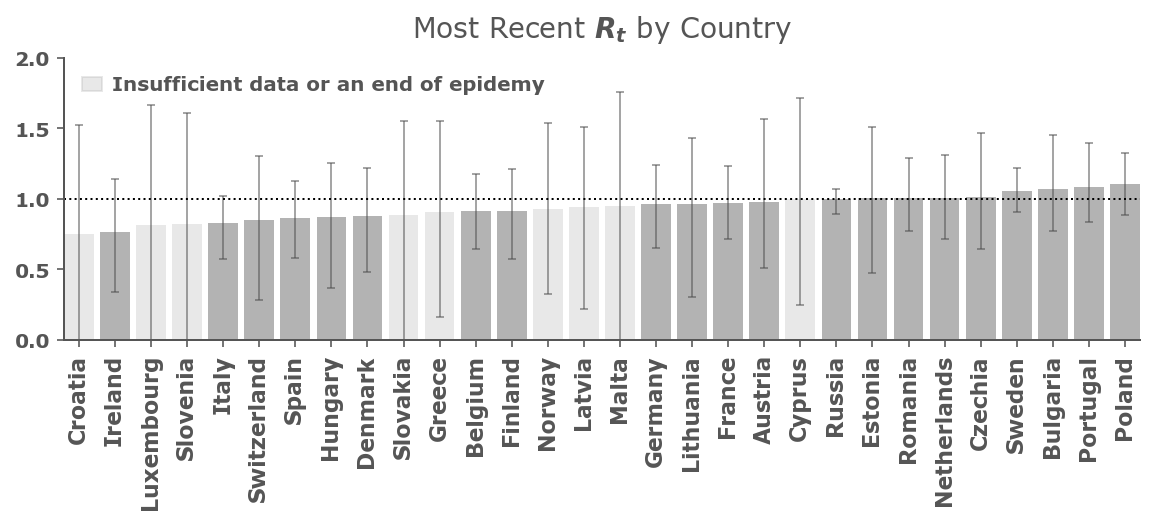

In [80]:
targets_rainier = final_results_rainier.index.get_level_values('region').isin(COUNTRIES_INCLUDED)
mr_rainier = final_results_rainier.loc[targets_rainier].groupby(level=0)[['median', 'upper_90', 'lower_90']].last()

mr_rainier.sort_values('median', inplace=True)
fig, ax = plot_standings(mr_rainier)

## Compare PYMC3's and Rainier's estimates for European countries

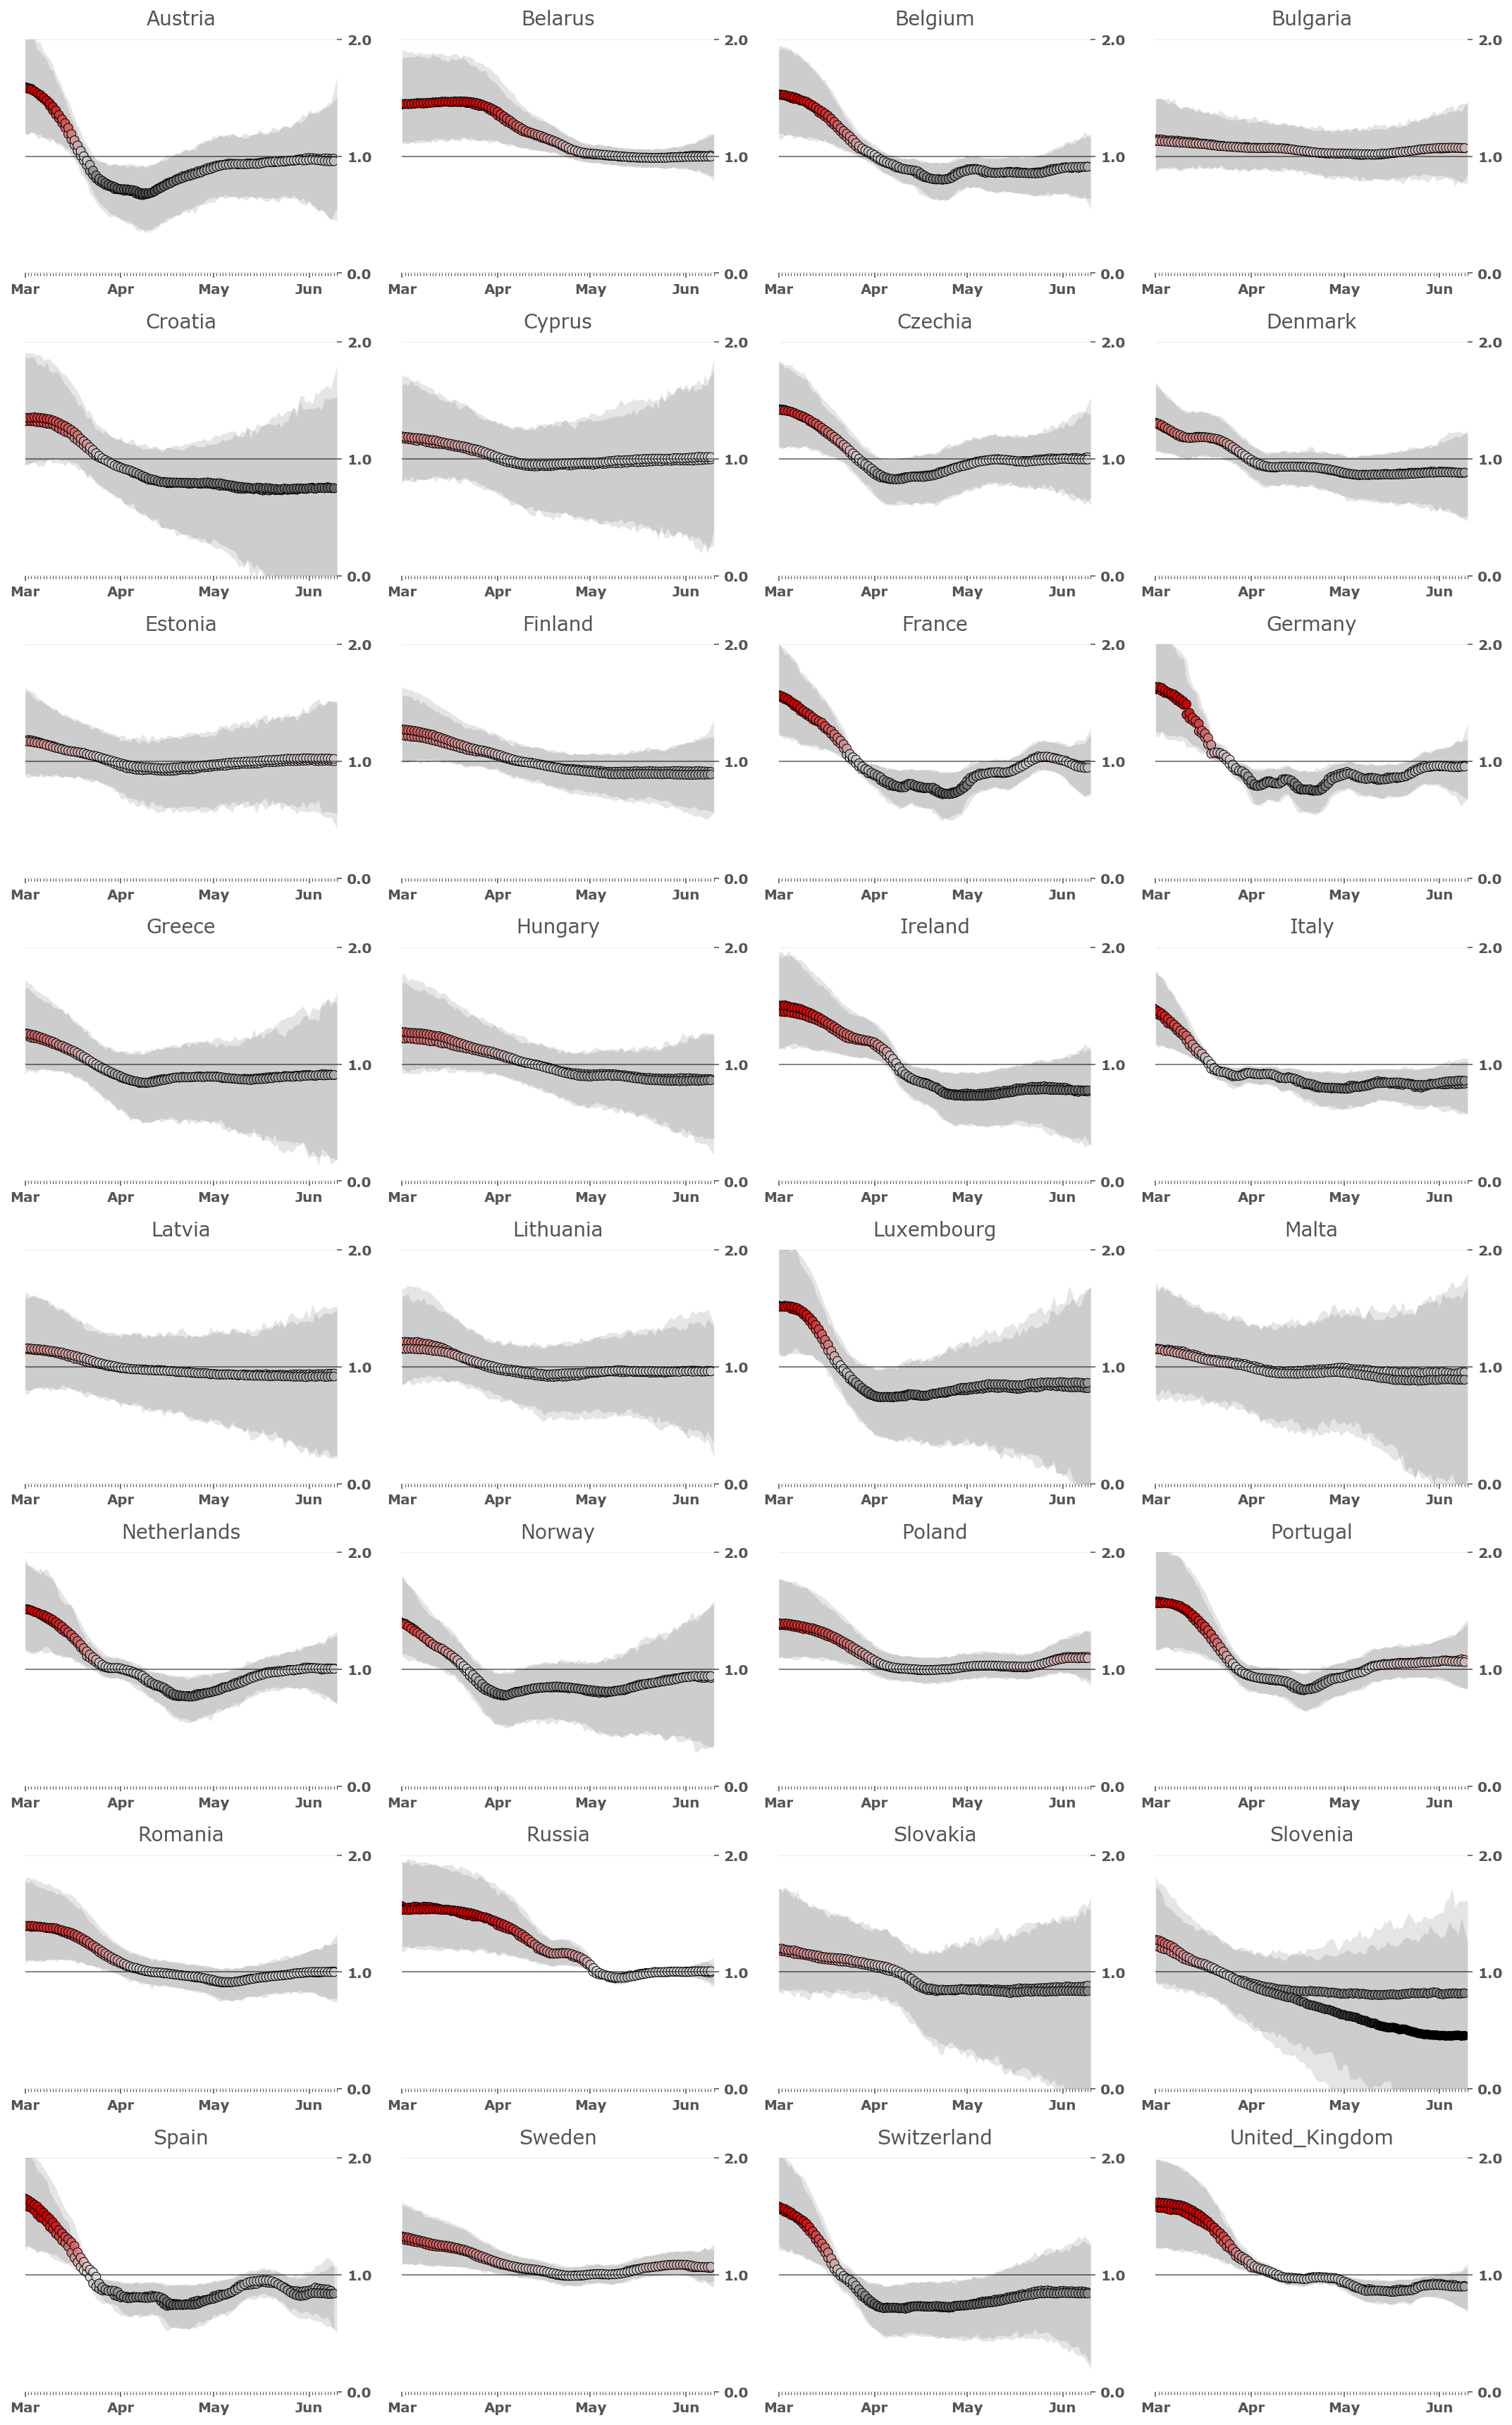

In [82]:
ncountries = len(final_results_rainier.index.unique(level='region'))
ncols = 4
nrows = int(np.ceil(ncountries / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

for i, (country_name, result) in enumerate(final_results_rainier.groupby('region')):
    plot_rt(result.iloc[1:], axes.flat[i], country_name)
for i, (country_name, result) in enumerate(final_results.groupby('region')):
    plot_rt(result.iloc[1:], axes.flat[i], country_name)

    
#for i, (country_name, result) in enumerate(final_results.groupby('country')):
#    plot_rt(result.iloc[1:], axes.flat[i], country_name, scatter_alpha=0.25)

fig.tight_layout()
fig.set_facecolor('w')